# Анализ уровня риска сердечно-сосудистых заболеваний в зависимости от различных факторов

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, precision_score, recall_score, log_loss

import warnings
warnings.simplefilter("ignore")

## Первый этап:

### 1.

In [2]:
df = pd.read_csv("Dataset/heart_data.csv")
df.head()

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


**Источник данных:** *Сайт **kaggle**: https://www.kaggle.com/datasets/thedevastator/exploring-risk-factors-for-cardiovascular-diseas/data* </br>
**Название столбцов:** *index, id, age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio* </br>
**Что в них содержится:** *индекс строки в таблице, идентификатор человека, возраст, пол, рост, вес, систолическое артериальное давление, диастолическое артериальное давление, уровень холестерина, уровень глюкозы, курит ли человек, употребляет ли человек алкоголь, занимается ли человек спортом, есть ли у человека сердечно-сосудистые заболевания* </br>
**Формат типа данных:** *int, int, float, int, int, float, int, int, int, int, int, int, int, int* </br>
**Тип данных с точки зрения анализа данных:** *количественный дискретный, количественный дискретный, количественный дискретный, категориальный бинарный, количественный дискретный, количественный непрерывный, количественный дискретный, количественный дискретный, категориальный порядковый, категориальный порядковый, категориальный бинарный, категориальный бинарный, категориальный бинарный, категориальный бинарный*

*Приведём переменную возраст к годам и возьмём только целую часть, удалим столбец **index** и приведём столбец **gender** к бинарному виду*

In [3]:
df["age"] = df["age"] // 365
df = df.drop(["index"], axis = 1)
df["gender"] = np.where(df["gender"] == 2, 0, 1)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,0,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,0,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0


### 2.

*Зная, что нормальное артериальное давление человека в состоянии покоя составляет 120 на 80 мм рт. ст., посмотрим, у скольких людей давление превышает норму*

In [4]:
df[(df["ap_hi"] > 120)].shape[0]

29263

*Отфильтровав данные, мы выявили, что людей с систолическим артериальным давлением со значением выше 120 мм рт. ст. было $29263$*

In [5]:
df[(df["ap_lo"] > 80)].shape[0]

21037

*Отфильтровав данные, мы выявили, что людей с диастолическим артериальным давлением со значением выше 80 мм рт. ст. было $21037$*

*Как известно, с возрастом риск сердечно-сосудистых заболеваний возрастает, особенно если человек курит и употребляет алкоголь*

In [6]:
df[(df["age"] > 60) & (df["smoke"] == 1) & (df["alco"] == 1) & (df["cardio"] == 1)].shape[0] / df[(df["age"] > 60) & (df["smoke"] == 1) & (df["alco"] == 1)].shape[0]

0.6836734693877551

*Отфильтровав данные, мы выявили, что у людей старше 60 лет, которые курят, употребляют алкоголь, имеют сердечно-сосудистые заболевания с вероятностью около $68.37\%$*

*Для дальнейшей работы будем иметь в виду, что в группу риска сердечно-сосудистых заболеваний входят люди в возрасте от $40$ лет*

In [7]:
df[(df["active"] == 1) & (df["smoke"] == 0) & (df["alco"] == 0) & (df["age"] < 40)].shape[0]

1219

*Отфильтровав данные, мы выявили, что людей, не находящихся в группе риска, которые занимаются спортом, не курят и не употребляют алкоголь, было $1219$*

*Построим гистограмму, иллюстрирующую количество людей не в группе риска с наличием или отсутствием сердечно-сосудистых заболеваний при условии ведения здорового образа жизни*

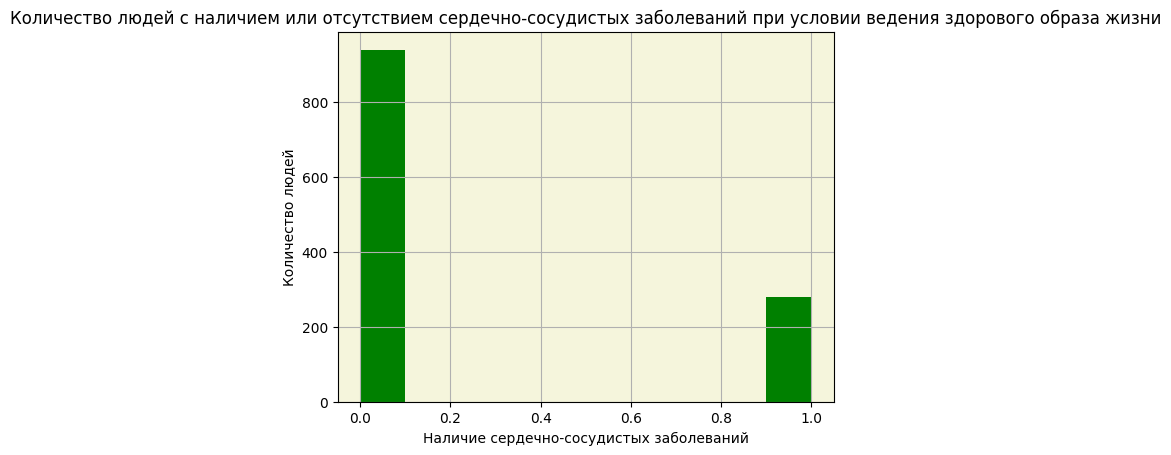

In [8]:
df[(df["active"] == 1) & (df["smoke"] == 0) & (df["alco"] == 0) & (df["age"] < 40)].hist(column = ["cardio"], color = "green")

plt.gca().set_facecolor("beige")
plt.title("Количество людей с наличием или отсутствием сердечно-сосудистых заболеваний при условии ведения здорового образа жизни")
plt.xlabel("Наличие сердечно-сосудистых заболеваний")
plt.ylabel("Количество людей")
plt.show();

In [9]:
df[(df["active"] == 1) & (df["smoke"] == 0) & (df["alco"] == 0) & (df["age"] < 40) & (df["cardio"] == 0)].shape[0] / df[(df["active"] == 1) & (df["smoke"] == 0) & (df["alco"] == 0) & (df["age"] < 40)].shape[0]

0.771123872026251

*Можно заметить, что если человек не находится в группе риска сердечно-сосудистых заболеваний и ведёт здоровый образ жизни, то у него больше шанс находиться в группе людей, у которых нет сердечно-сосудистых заболеваний, - он составляет около $77.11\%$*

*Посмотрим, как влияют показатели крови на риск сердечно-сосудистых заболеваний*

In [10]:
df[(df["cholesterol"] == 1) & (df["gluc"] == 1) & (df["age"] < 40) & (df["cardio"] == 0)].shape[0] / df[(df["cholesterol"] == 1) & (df["gluc"] == 1) & (df["age"] < 40)].shape[0]

0.8111888111888111

*Отфильтровав данные, мы выявили, что у людей, у которых уровень холестерина и глюкозы в норме и которые не находятся в группе риска сердечно-сосудистых заболеваний, шанс не иметь сердечно-сосудистое заболевание составляет около $81.12\%$*

*Построим гистограмму, иллюстрирующую количество людей не в группе риска с наличием или отсутствием сердечно-сосудистых заболеваний при условии нормальных показателей уровня холестерина и глюкозы в крови*

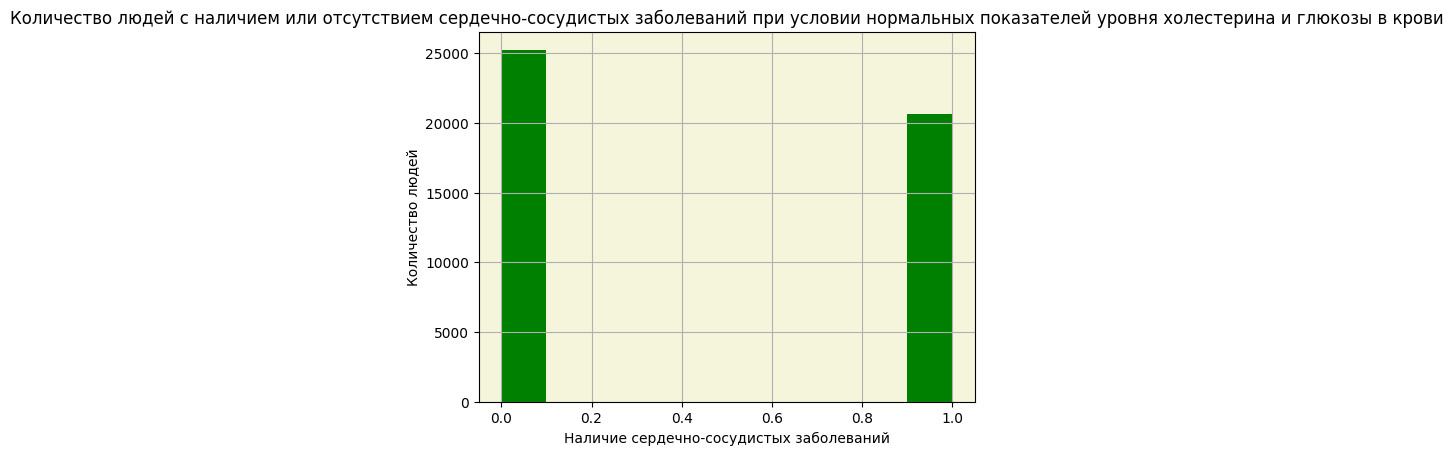

In [11]:
df[(df["cholesterol"] == 1) & (df["gluc"] == 1) & (df["age"] > 40)].hist(column = ["cardio"], color = "green")

plt.gca().set_facecolor("beige")
plt.title("Количество людей с наличием или отсутствием сердечно-сосудистых заболеваний при условии нормальных показателей уровня холестерина и глюкозы в крови")
plt.xlabel("Наличие сердечно-сосудистых заболеваний")
plt.ylabel("Количество людей")
plt.show();

In [12]:
df[(df["cholesterol"] == 1) & (df["gluc"] == 1) & (df["age"] > 40) & (df["cardio"] == 1)].shape[0] / df[(df["cholesterol"] == 1) & (df["gluc"] == 1) & (df["age"] > 40)].shape[0]

0.44987913499858445

*Можно заметить, что у человека, находящегося в группе риска сердечно-сосудистых заболеваний и имеющего нормальные показатели уровня холестерина и глюкозы в крови, шанс иметь сердечно-сосудистое заболевание составляет около $44.99\%$*

### 3.

In [13]:
df_sorted_age = df.sort_values(by = "age")
df_sorted_age

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
6219,8850,29,1,175,59.0,120,80,1,1,0,0,1,0
22343,31922,29,0,175,92.0,100,60,1,1,0,0,1,0
30666,43842,29,1,159,59.0,120,80,1,1,0,0,1,0
55905,79749,30,1,160,59.0,110,70,1,1,0,0,1,0
36998,52863,39,1,163,74.0,110,70,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35152,50229,64,1,170,82.0,130,80,1,1,0,0,1,1
70,95,64,1,155,57.0,120,80,1,1,0,0,1,1
35163,50243,64,1,172,71.0,140,90,1,1,0,0,0,1
27304,39043,64,1,160,62.0,160,90,1,1,0,0,1,1


*Здесь мы выполнили сортировку данных выборки по возрасту людей (в порядке возрастания), и можно заметить, что самому молодому человеку в этой выборке $29$ лет, а возраст старшего человека составляет $64$ года*

In [14]:
df_sorted_weight = df.sort_values(by = "weight")
df_sorted_weight

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
57858,82567,51,0,165,10.0,180,1100,2,2,0,0,1,1
33817,48318,59,0,178,11.0,130,90,1,1,0,0,1,1
60188,85931,59,1,162,21.0,120,80,2,1,0,0,1,1
29488,42156,55,0,177,22.0,120,80,1,1,1,1,1,0
26806,38312,63,1,157,23.0,110,80,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60592,86506,51,0,180,180.0,140,100,3,1,0,0,1,1
36780,52564,53,1,161,181.0,180,1100,2,1,0,0,1,1
61285,87498,57,0,180,183.0,110,80,3,3,0,1,1,1
435,618,45,1,186,200.0,130,70,1,1,0,0,0,0


*Далее мы выполнили сортировку по весу в порядке возрастания, и можно заметить, что минимальный вес в выборке - $10$ кг, а максимальный - $200$ кг*

In [15]:
df_sorted_ap_hi = df.sort_values(by = "ap_hi")
df_sorted_ap_hi

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
35040,50055,63,0,168,59.0,-150,80,1,1,0,0,1,1
23988,34295,50,1,162,74.0,-140,90,1,1,0,0,1,1
46627,66571,64,0,160,59.0,-120,80,1,1,0,0,0,0
25240,36025,40,0,168,50.0,-120,80,2,1,0,0,0,1
16021,22881,60,0,161,90.0,-115,70,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25519,36414,58,1,169,71.0,14020,80,3,3,0,0,1,1
25464,36339,43,0,169,75.0,14020,80,2,1,0,0,1,1
46912,66998,46,0,180,78.0,14020,90,1,1,0,0,1,1
47253,67502,54,1,160,65.0,14020,90,1,1,0,0,1,0


*Затем мы выполнили сортировку по систолическому артериальному давлению в порядке возрастания, и можно заметить, что минимальное систолическое артериальное давление составляет: $-150$ мм рт. ст., а максимальное: $16020$ мм рт. ст.*

## Второй этап:

### 1.

In [16]:
df["age"].value_counts().sort_index()

age
29       3
30       1
39    1780
40    1622
41    1903
42    1418
43    2031
44    1514
45    2087
46    1625
47    2197
48    1811
49    3417
50    3216
51    3368
52    3279
53    3868
54    3605
55    3927
56    3607
57    3686
58    3409
59    3576
60    3200
61    2728
62    2199
63    2736
64    2187
Name: count, dtype: int64

*Построим столбчатую диаграмму для визуализации предыдущих значений и сделаем вывод по этой таблице*

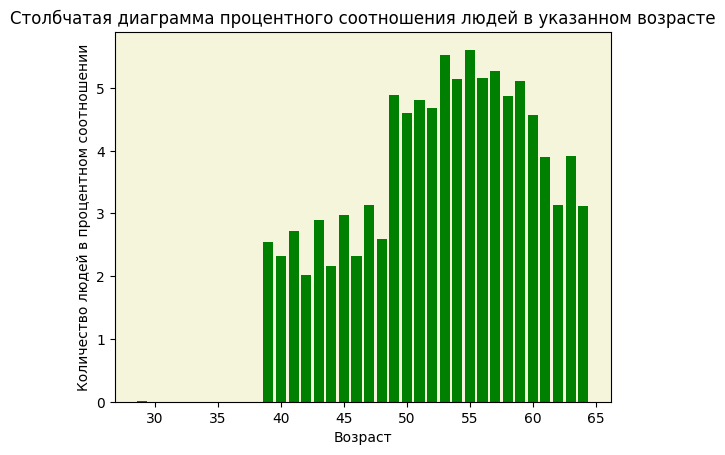

In [17]:
ages = df["age"].value_counts().to_dict()

percents = []

for i in ages.keys():
    percents.append((ages[i] / len(df["age"])) * 100)
    
plt.bar(ages.keys(), percents, color = "green")
    
plt.gca().set_facecolor("beige")
plt.title("Столбчатая диаграмма процентного соотношения людей в указанном возрасте")
plt.xlabel("Возраст")
plt.ylabel("Количество людей в процентном соотношении")
plt.show();

*Из этой столбчатой диаграммы мы понимаем, что большая часть людей расположена в возрасте $49 - 60$*

In [18]:
df["cardio"].value_counts().sort_index()

cardio
0    35021
1    34979
Name: count, dtype: int64

*Тут мы можем сделать вывод, что выборка у нас поделилась практически на две равные части, у кого есть сердечно-сосудичтые заболевания и у кого их нет*

In [19]:
df["smoke"].value_counts().sort_index()

smoke
0    63831
1     6169
Name: count, dtype: int64

*Тут мы можем сделать вывод, что в выборке большая часть людей не курит*

### 2.

*Как мы могли заметить риск сердечно-сосудистого заболевания сильно зависит от возроста, поэтому построим частотную таблицу по возрасту для тех у кого есть сердечно-сосудистое заболевание и у кого нет отдельно и сравним*

In [20]:
temp = df_sorted_age.groupby("cardio")["age"].value_counts().sort_index()
temp

cardio  age
0       29        3
        30        1
        39     1348
        40     1274
        41     1339
        42      994
        43     1287
        44      970
        45     1236
        46      986
        47     1138
        48      985
        49     1968
        50     1968
        51     1775
        52     1758
        53     1918
        54     1855
        55     1755
        56     1676
        57     1594
        58     1510
        59     1377
        60     1332
        61      871
        62      724
        63      743
        64      636
1       39      432
        40      348
        41      564
        42      424
        43      744
        44      544
        45      851
        46      639
        47     1059
        48      826
        49     1449
        50     1248
        51     1593
        52     1521
        53     1950
        54     1750
        55     2172
        56     1931
        57     2092
        58     1899
        59     2199
        

*По таким данным сложно сделать вывод, поэтому построим гистограмму*

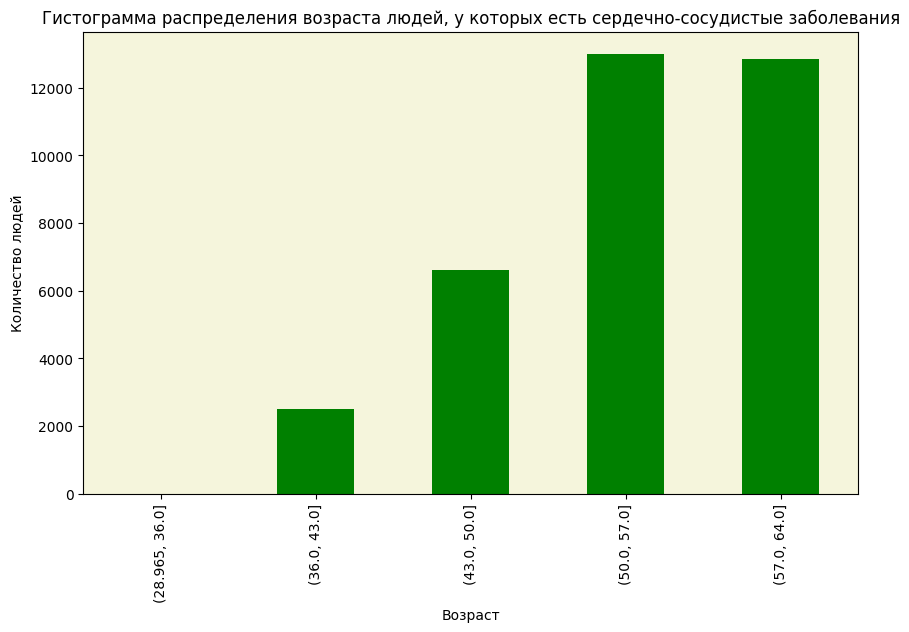

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

counts = df[df["cardio"] == 1].groupby(pd.cut(df["age"], bins = 5))["cardio"].count()
counts.plot(kind='bar', color='green', ax=ax)

ax.set_facecolor("beige")
ax.set_title("Гистограмма распределения возраста людей, у которых есть сердечно-сосудистые заболевания")
ax.set_xlabel("Возраст")
ax.set_ylabel("Количество людей")
plt.show();

*Можно сделать вывод, что возраст, с которого с большей вероятностью у человека поясляется сердечно-сосудистое заболевание - это промежуток от 50 до 64 лет в нашей выборке*

### 3.

In [22]:
df["bmi"] = round(df["weight"] / ((df["height"] / 100) ** 2), 3)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,50,0,168,62.0,110,80,1,1,0,0,1,0,21.967
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.928
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1,23.508
3,3,48,0,169,82.0,150,100,1,1,0,0,1,1,28.710
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0,23.011


*Сейчас мы создали новую переменную индекс массы телы, по которму сможем определить в норме ли вес человека, которым напрямую влияет на риск сердечно-сосудистых заболеваний*

## Третий этап:

### 1.

In [23]:
df["bmi"].mean()

np.float64(27.556504614285714)

*Тут мы нашли среднее значение для столбца "индекс массы тела" и получили, что балансировочная точка для него приблизительно равна $27.56$*

In [24]:
df["bmi"].mode()

0    23.875
Name: bmi, dtype: float64

*Тут мы нашли значение, которое в выборке встречается чаще всего: $23.875$*

In [25]:
df["bmi"].value_counts()

bmi
23.875    1157
23.437     651
24.221     489
25.712     365
22.039     358
          ... 
38.460       1
38.860       1
53.333       1
24.957       1
26.388       1
Name: count, Length: 3593, dtype: int64

*Тут мы нашли значение, которое в выборке встречается чаще всего: $23.875$, по частотной таблице можно определить, что такое значение индекса массы тела встречается у **1157** людей*

In [26]:
df["bmi"].median()

np.float64(26.374000000000002)

*Тут мы нашли середину для распределения индекса массы тела, она приблизительно равна $26.374$*

In [27]:
df["age"].mean()

np.float64(52.840671428571426)

*Тут мы нашли среднее значение для столбца "возраст" и получили, что балансировочная точка для него приблизительно равна $53$ года*

In [28]:
df["age"].mode()

0    55
Name: age, dtype: int64

*Тут мы нашли значение, которое в выборке встречается чаще всего: $55$ лет*

In [29]:
df["age"].median()

np.float64(53.0)

*Тут мы нашли середину для распределения возраста, она приблизительно равна $53$ года*

In [30]:
df["active"].mode()

0    1
Name: active, dtype: int64

*Посчитав моду для столбца **active**, мы выявили, что в нашей выборке большая часть людей занимается спортом*

In [31]:
df["gender"].mode()

0    1
Name: gender, dtype: int64

*Посчитав моду для столбца **gender**, мы выявили, что большая часть людей в выборке - это мужчины*

In [32]:
df["cholesterol"].mode()

0    1
Name: cholesterol, dtype: int64

*Посчитав моду для уровня холестерина в крови у людей в выборке, мы выявили, что у большей части людей уровень холестерина в крове находится в норме*

### 2.

*Сейчас мы посмотрим на выбросы по нескольким переменным и заменим их на медианные значения*

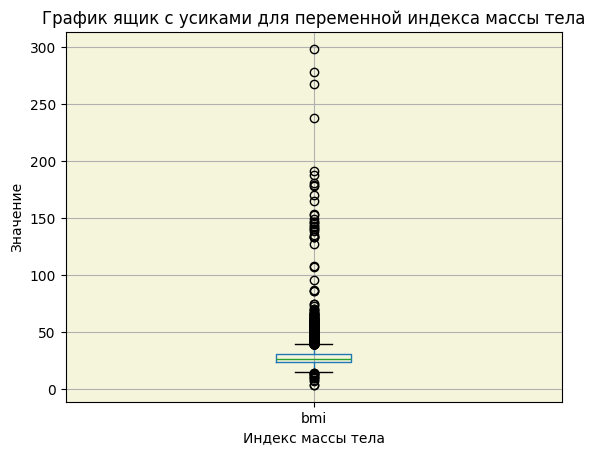

In [33]:
plt.gca().set_facecolor("beige")
plt.title("График ящик с усиками для переменной индекса массы тела")
plt.xlabel("Индекс массы тела")
plt.ylabel("Значение")
df.boxplot(column=["bmi"]);

*Тут мы построили график "ящик с усами", чтобы посмотреть на выбросы для переменной, которая обозначает индекс массы тела, и обнаружили, что большая часть выбросов расположена выше, чем **Q3 + 1.5 * IQR**, и что наибольшее значение, которое достигается, составляет около $300$*

*Теперь вернёмся ко 2-му пункту 2-го этапа, потому что ранее мы не могли построить график, иллюстрирующий распределение индекса массы тела, из-за большого количества выбросов в данных, которые не позволяли представить качественную гистограмму*

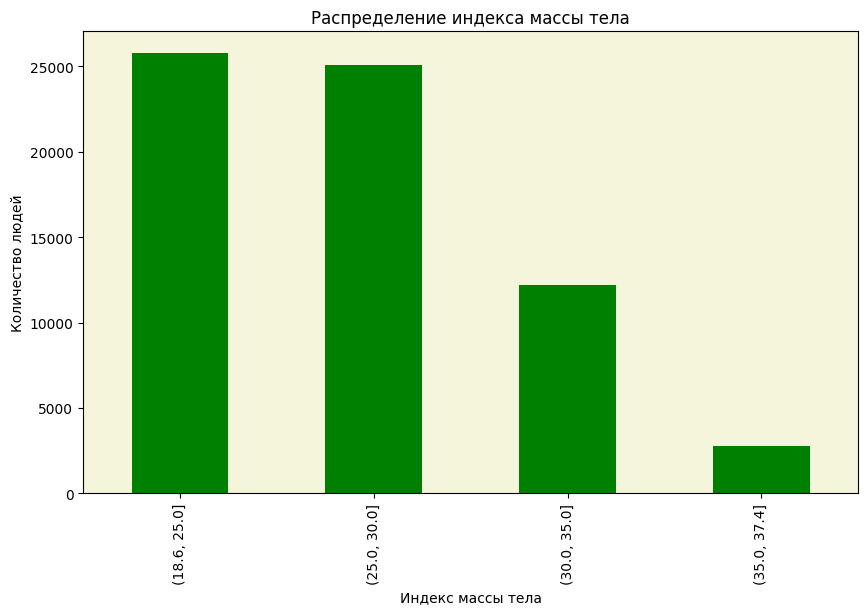

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

bin_edges = [18.6, 25, 30, 35, 37.4]
counts = df.groupby(pd.cut(df["bmi"], bins=bin_edges))["cardio"].count()
counts.plot(kind='bar', color='green', ax=ax)

ax.set_facecolor('beige')
ax.set_title("Распределение индекса массы тела")
ax.set_xlabel("Индекс массы тела")
ax.set_ylabel("Количество людей")
plt.show();

*Можно заметить, что у нас большая часть людей в выборке имеет лишний вес, который напрямую влияет на риск сердечно-сосудисых заболеваний*

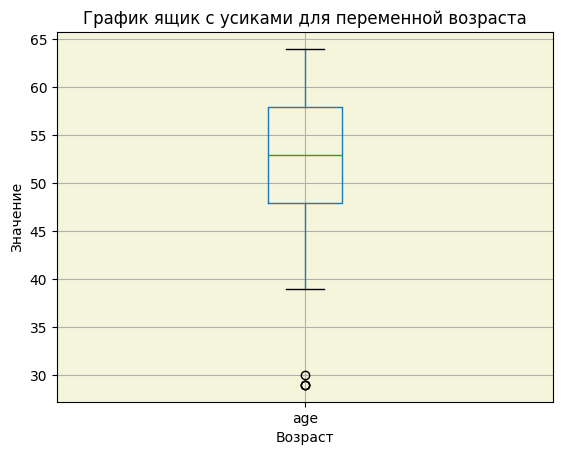

In [35]:
plt.gca().set_facecolor("beige")
plt.title("График ящик с усиками для переменной возраста")
plt.xlabel("Возраст")
plt.ylabel("Значение")
df.boxplot(column=["age"]);

*Тут мы построили график ящик с усами, чтобы посмотреть на выбросы для переменной, которая обозначает возраст, и обнаружили, что выбросов не так много и они расположены ниже, чем **Q1 - 1.5 * IQR***

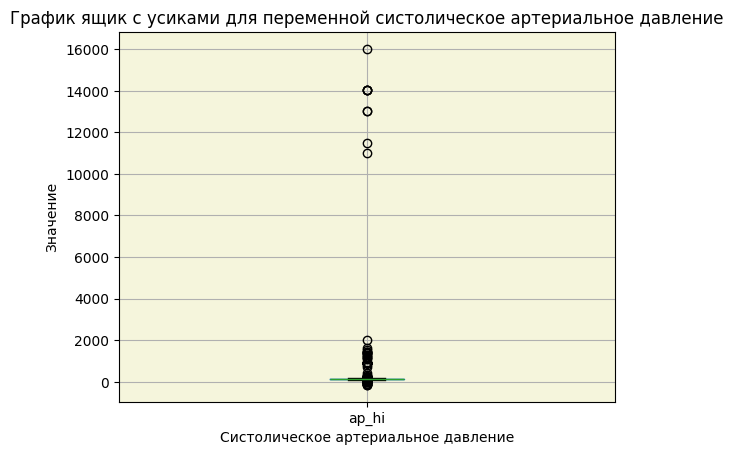

In [36]:
plt.gca().set_facecolor("beige")
plt.title("График ящик с усиками для переменной систолическое артериальное давление")
plt.xlabel("Систолическое артериальное давление")
plt.ylabel("Значение")
df.boxplot(column=['ap_hi']);

*Тут мы построили график ящик с усами, чтобы посмотреть на выбросы для переменной, которая обозначает систолическое артериальное давление, и обнаружили, что большая часть выбросов расположена выше, чем **Q3 + 1.5 * IQR**, и что наибольшее значение, которое достигается, составляет около $16000$*

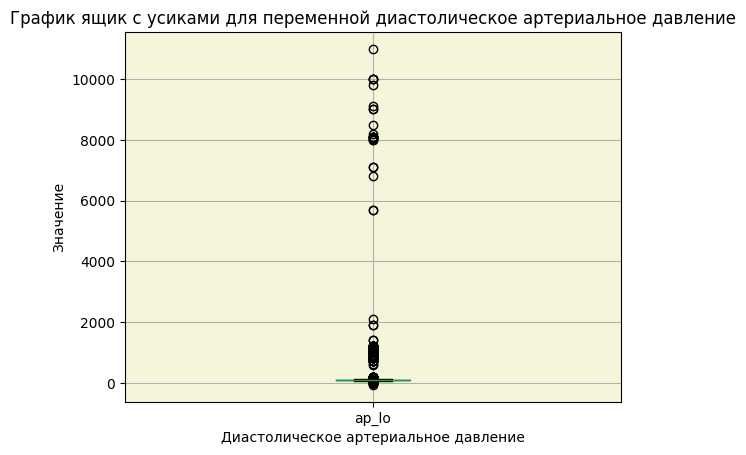

In [37]:
plt.gca().set_facecolor("beige")
plt.title("График ящик с усиками для переменной диастолическое артериальное давление")
plt.xlabel("Диастолическое артериальное давление")
plt.ylabel("Значение")
df.boxplot(column=['ap_lo']);

*Тут мы построили график ящик с усами, чтобы посмотреть на выбросы для переменной, которая обозначает диастолическое артериальное давление, и обнаружили, что большая часть выбросов расположена выше, чем **Q3 + 1.5 * IQR**, и что наибольшее значение, которое достигается, больше, чем $10000$*

### 3.

*Вычислим межквартильный размах и среднеквадратичное отклонение от среднего для переменной индекса массы тела*

In [38]:
q_1 = df["bmi"].quantile(0.25)
q_3 = df["bmi"].quantile(0.75)

q_3 - q_1

np.float64(6.347000000000001)

In [39]:
df["bmi"].std()

np.float64(6.091525163932184)

*Результаты отличаются, но на достаточно небольшое значение, поэтому можно сделать вывод, что выбросов немного*

### 4.

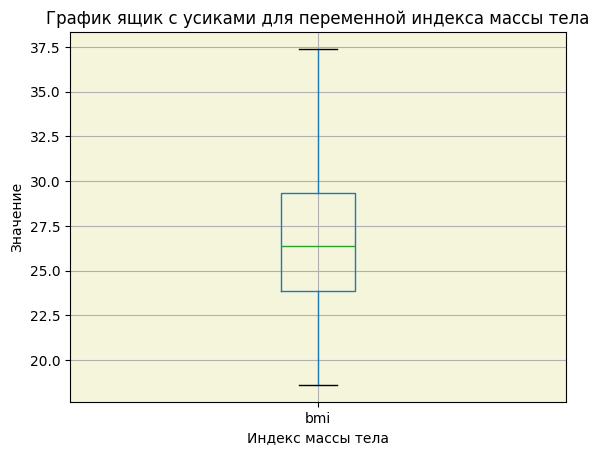

In [40]:
low_q = df["bmi"].quantile(0.01)
high_q = df["bmi"].quantile(0.95)
median = df["bmi"].median()

df["bmi"] = df["bmi"].apply(lambda x: median if ((x < low_q) or (x > high_q)) else x)

plt.gca().set_facecolor("beige")
plt.title("График ящик с усиками для переменной индекса массы тела")
plt.xlabel("Индекс массы тела")
plt.ylabel("Значение")
df.boxplot(column=["bmi"]);

In [41]:
df["bmi"].mean()

np.float64(26.823860557142854)

In [42]:
df["bmi"].mode()

0    26.374
Name: bmi, dtype: float64

In [43]:
df["bmi"].median()

np.float64(26.374000000000002)

*После того как мы заменили выбросы на медиану, можно сделать вывод, что: значение медианы не изменилось, самое частое значение стало медианой, а за счёт того, что выбросов было больше в верхней части и мы их заменили, среднее значение уменьшалось*

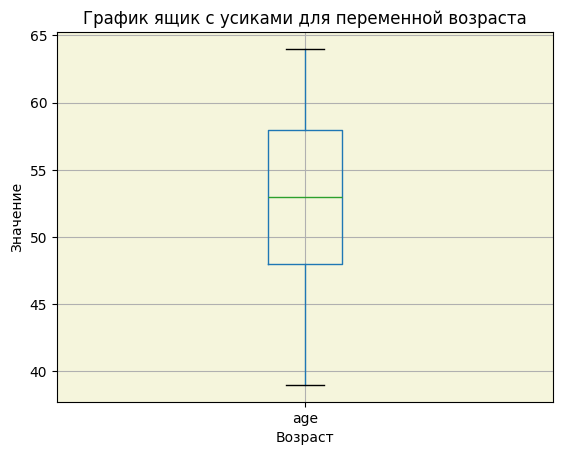

In [44]:
low_q = df["age"].quantile(0.01)
median = df["age"].median()

df["age"] = df["age"].apply(lambda x: median if ((x < low_q)) else x)

plt.gca().set_facecolor("beige")
plt.title("График ящик с усиками для переменной возраста")
plt.xlabel("Возраст")
plt.ylabel("Значение")
df.boxplot(column=["age"]);

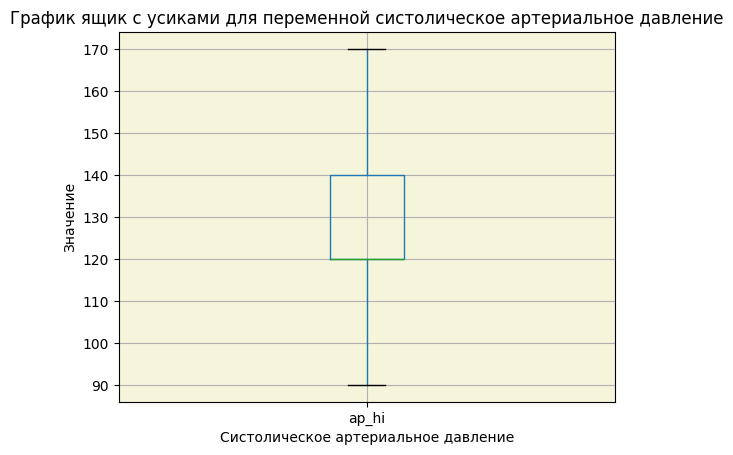

In [45]:
low_q = df["ap_hi"].quantile(0.01)
high_q = df["ap_hi"].quantile(0.98)
median = df["ap_hi"].median()

df["ap_hi"] = df["ap_hi"].apply(lambda x: median if ((x < low_q) or (x > high_q)) else x)

plt.gca().set_facecolor("beige")
plt.title("График ящик с усиками для переменной систолическое артериальное давление")
plt.xlabel("Систолическое артериальное давление")
plt.ylabel("Значение")
df.boxplot(column=['ap_hi']);

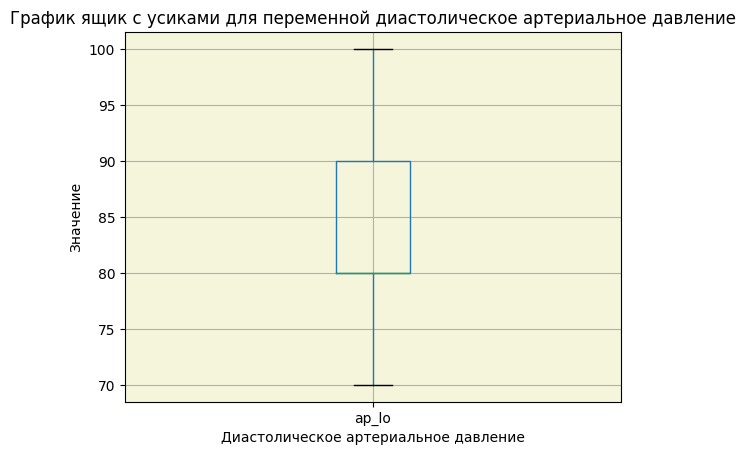

In [46]:
low_q = df["ap_lo"].quantile(0.05)
high_q = df["ap_lo"].quantile(0.97)
median = df["ap_lo"].median()

df["ap_lo"] = df["ap_lo"].apply(lambda x: median if ((x < low_q) or (x > high_q)) else x)

plt.gca().set_facecolor("beige")
plt.title("График ящик с усиками для переменной диастолическое артериальное давление")
plt.xlabel("Диастолическое артериальное давление")
plt.ylabel("Значение")
df.boxplot(column=['ap_lo']);

*Кажется, что в большей части случаем выбросы лучше заменять на медианные значения, так как медиана менее чувствительна к выбросам и выбросов может быть настолько много, что если мы их удаляем, то потеряем большую часть выборки*

### 5.

In [47]:
df.isna().mean()

id             0.0
age            0.0
gender         0.0
height         0.0
weight         0.0
ap_hi          0.0
ap_lo          0.0
cholesterol    0.0
gluc           0.0
smoke          0.0
alco           0.0
active         0.0
cardio         0.0
bmi            0.0
dtype: float64

*По таблице видно, что у нас нет пропусков в данных*

## Четвёртый этап:

### 1.

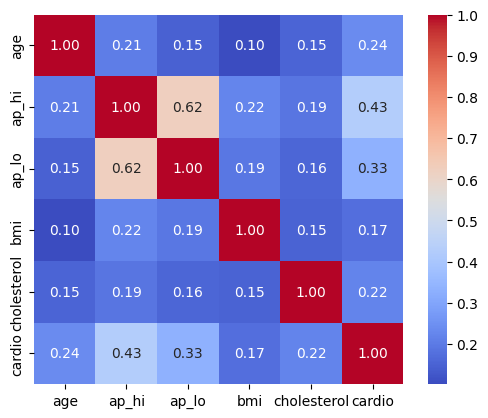

In [48]:
sns.heatmap(df[["age", "ap_hi", "ap_lo", "bmi", "cholesterol",  "cardio"]].corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True);

### 2.

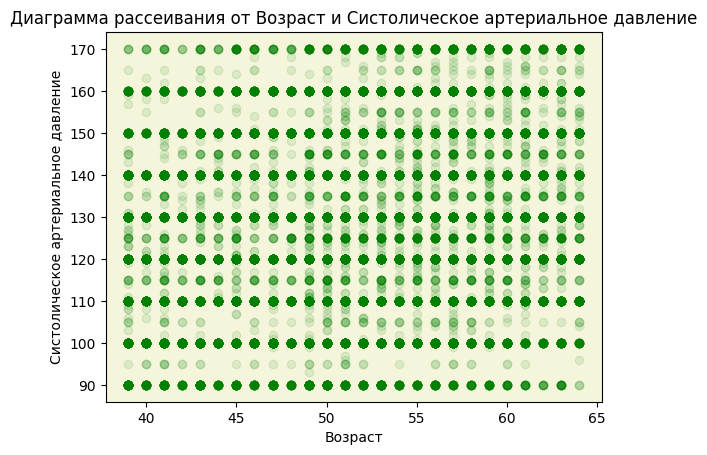

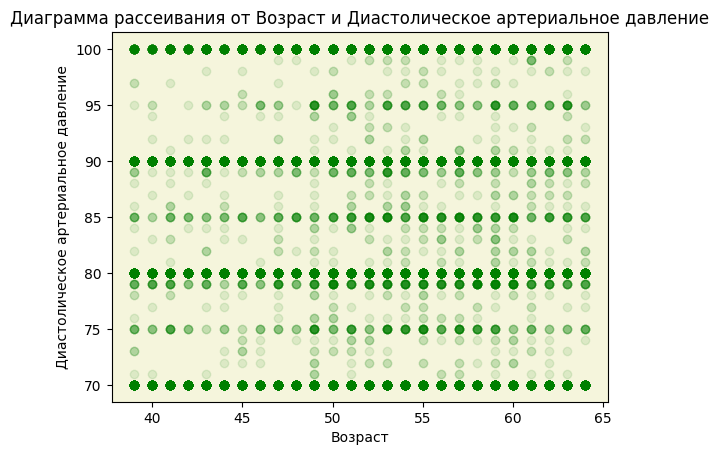

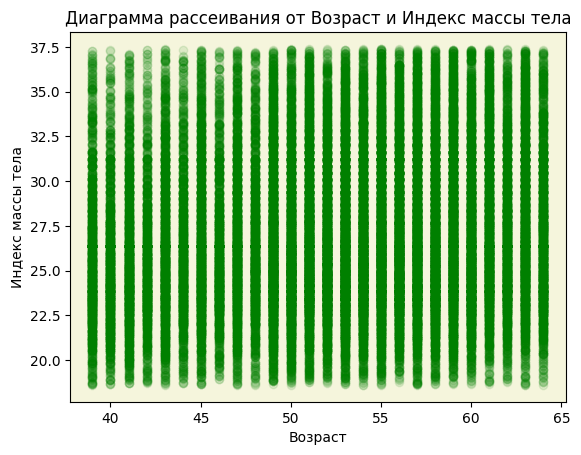

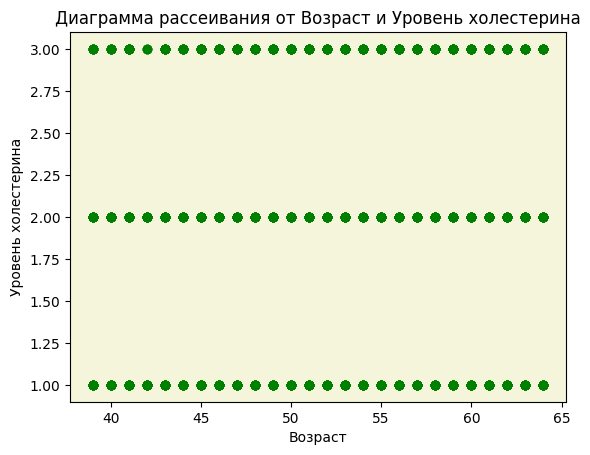

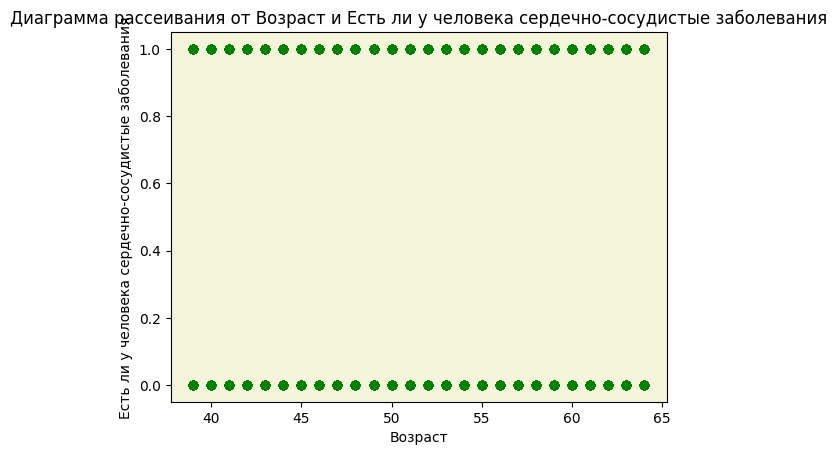

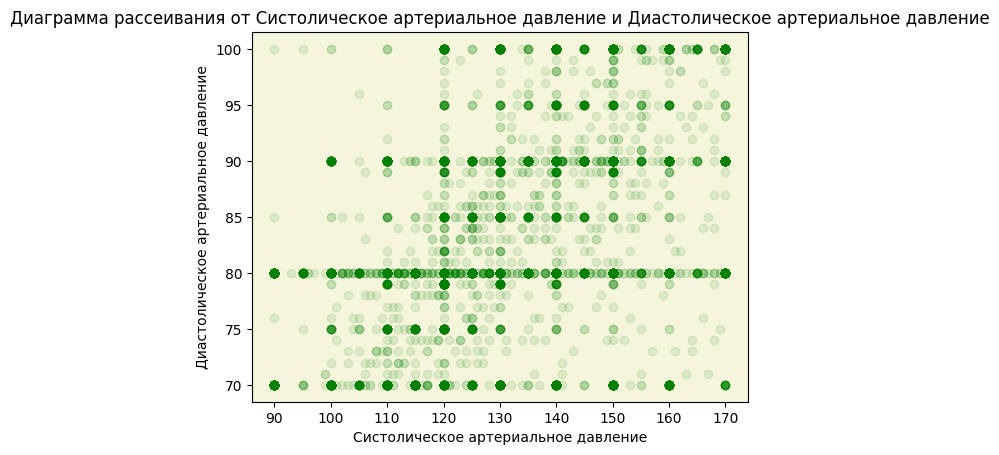

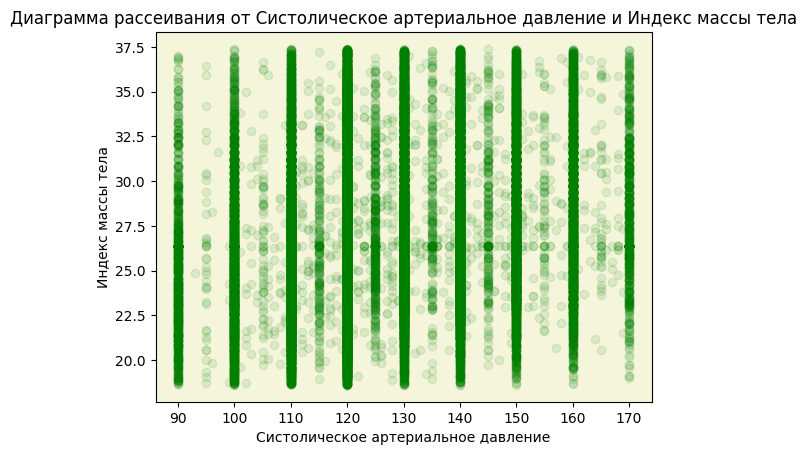

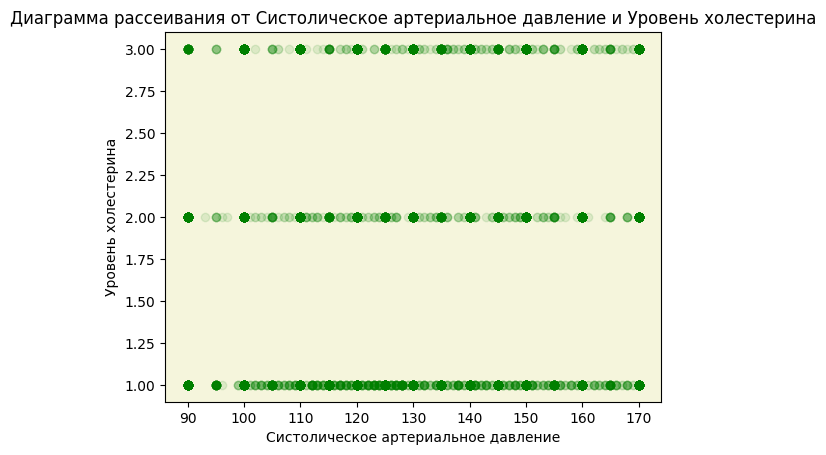

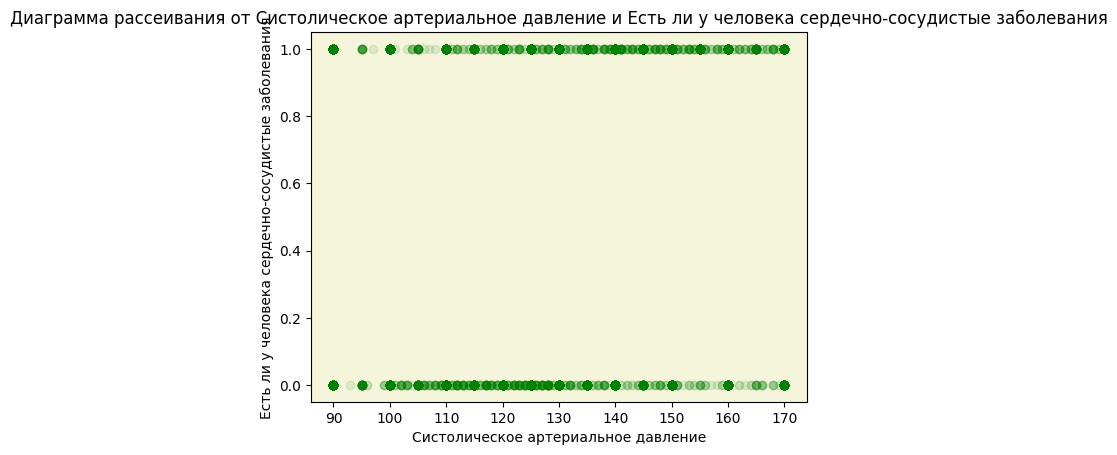

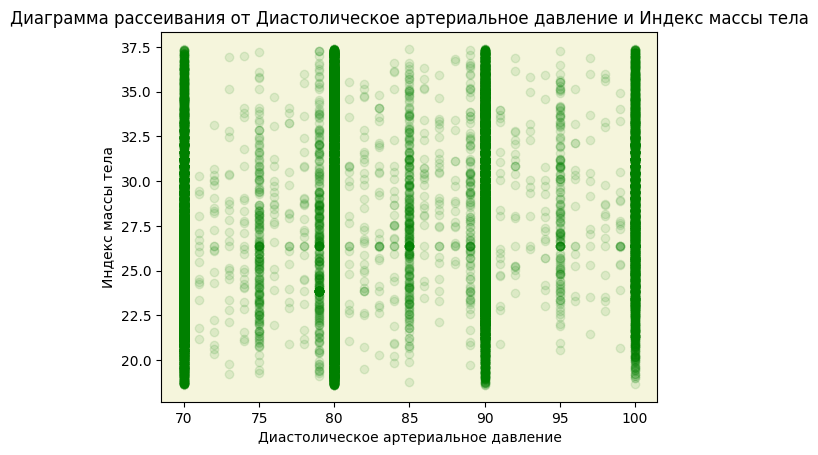

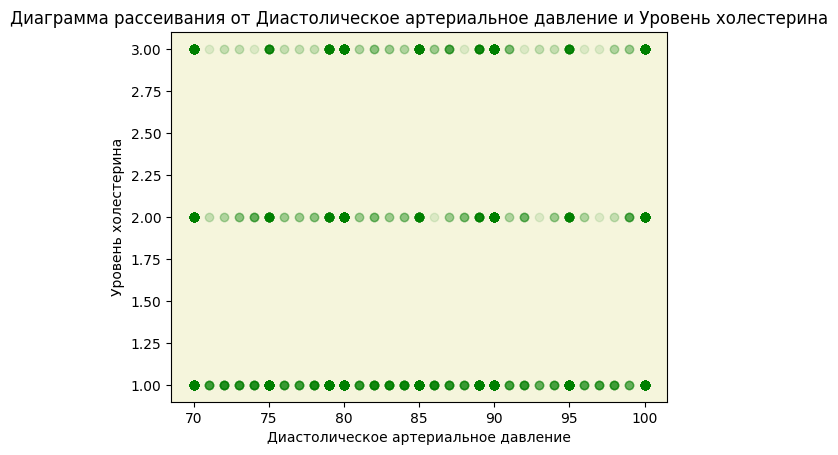

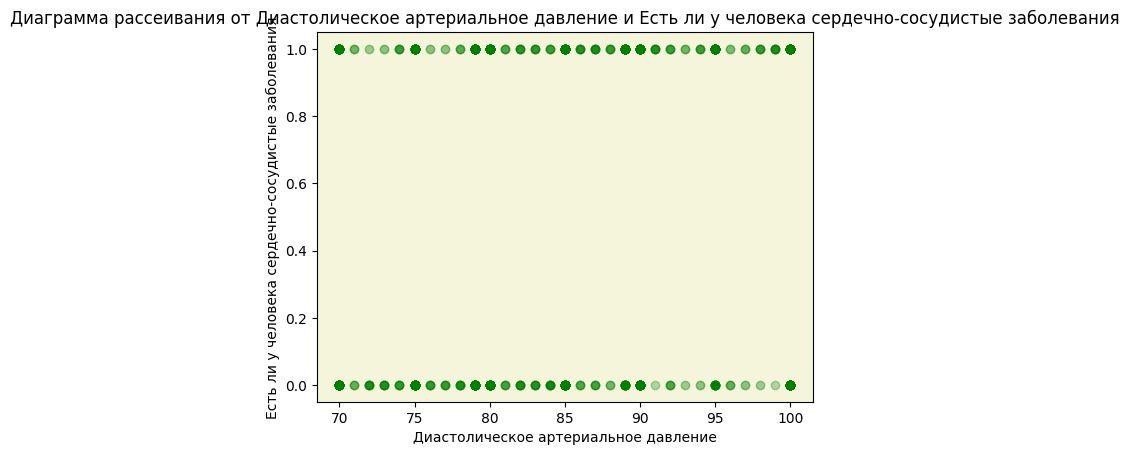

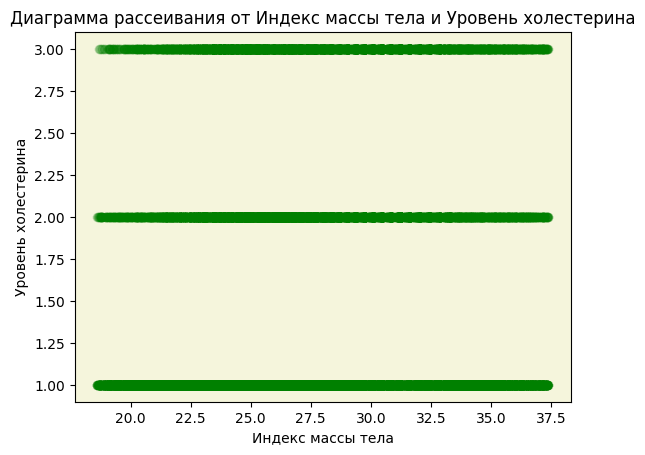

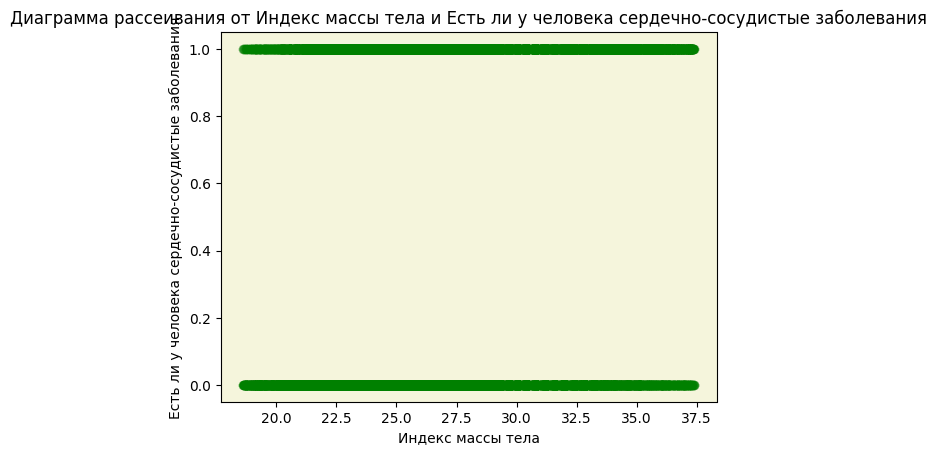

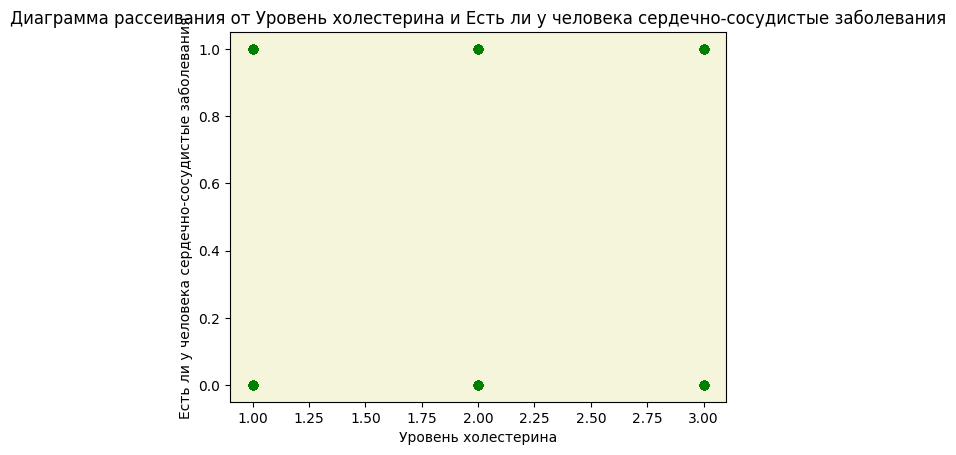

<Figure size 640x480 with 0 Axes>

In [49]:
columns = ["age", "ap_hi", "ap_lo", "bmi", "cholesterol",  "cardio"]
dict_columns = {"age": "Возраст", "ap_hi": "Систолическое артериальное давление", "ap_lo": "Диастолическое артериальное давление", "bmi": "Индекс массы тела", "cholesterol": "Уровень холестерина", "cardio": "Есть ли у человека сердечно-сосудистые заболевания"}

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        plt.gca().set_facecolor("beige")
        plt.scatter(df[columns[i]], df[columns[j]], color = "green", alpha = 0.1)
        plt.xlabel(f"{dict_columns[columns[i]]}")
        plt.ylabel(f"{dict_columns[columns[j]]}")
        plt.title(f"Диаграмма рассеивания от {dict_columns[columns[i]]} и {dict_columns[columns[j]]}")
        plt.figure()

### 3.

*Рассмотрим корреляцию между **ap_hi** и **ap_lo**, она равна 0.62, поэтому можно сделать вывод, что есть **заметная** связь и наблюдается функциональная зависимость*

*Рассмотрим корреляцию между **ap_hi** и **cardio**, она равна 0.43, поэтому можно сделать вывод, что есть **умеренная** связь, определить зависимость невозможно, так как **cardio** - это категориальная переменная*

*Рассмотрим корреляцию между **age** и **bmi**, она равна 0.1, поэтому можно сделать вывод, что есть **слабая** связь, точки расположены хаотично*

*Рассмотрим корреляцию между **cholesterol** и **age**, она равна 0.15, поэтому можно сделать вывод, что есть **слабая** связь, определить зависимость невозможно, так как **cholesterol** - это категориальная переменная*

*Рассмотрим корреляцию между **bmi** и **ap_hi**, она равна 0.22, поэтому можно сделать вывод, что есть **слабая** связь, возможно имеется функциональная зависимость*

## Пятый этап

*Зададим признаки и целевую переменную*

In [50]:
X = df[["age", "gender", "bmi", "ap_hi", "ap_lo", "cholesterol", "gluc", "smoke", "alco", "active"]]
y = df["cardio"]

*Разделение на выборки*

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42)

*Нормализация данных*

In [52]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

*Использование кросс-валидации*

In [53]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

*Обучение модели*

In [54]:
models_dict = {
    "log-reg": LogisticRegression(),
    "sgd": SGDClassifier()
}

In [55]:
models = []
for key_model in models_dict.keys():
    model = models_dict[key_model]

    accuracies = np.zeros(kf.n_splits)
    precisions = np.zeros(kf.n_splits)
    recalls = np.zeros(kf.n_splits)
    f1_scores = np.zeros(kf.n_splits)

    for index, value in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[value[0]], X.iloc[value[1]]
        y_train, y_test = y.iloc[value[0]], y.iloc[value[1]]
    
        model.fit(X_train, y_train)
        models.append(model)
        y_pred = model.predict(X_test)
        accuracies[index] = accuracy_score(y_test, y_pred)
        precisions[index] = precision_score(y_test, y_pred, average='weighted')
        recalls[index] = recall_score(y_test, y_pred, average='weighted')
        f1_scores[index] = f1_score(y_test, y_pred, average='weighted')

    print("Model: " + key_model, "Mean Accuracy: " + str(accuracies.mean()), "Mean Precision: " + str(precisions.mean()), "Mean Recall: " + str(recalls.mean()), "Mean F1 Score: " + str(f1_scores.mean()), sep='\n')
    print()

Model: log-reg
Mean Accuracy: 0.6990714285714287
Mean Precision: 0.6998400233190495
Mean Recall: 0.6990714285714287
Mean F1 Score: 0.6987915606358469

Model: sgd
Mean Accuracy: 0.7078571428571429
Mean Precision: 0.7094718136983496
Mean Recall: 0.7078571428571429
Mean F1 Score: 0.7071991273126262



*Проверка соотношений классов*

In [56]:
df["cardio"].value_counts(normalize=True)

cardio
0    0.5003
1    0.4997
Name: proportion, dtype: float64

*Из этих данных можно сделать вывод, что модель не константная*

*Сохраняем модель и стандартизатор*

In [ ]:
joblib.dump(models[1], "Model/model.pkl")
joblib.dump(scaler, "Normalization/scaler.pkl");